# Vietnam Rice Sims Paper - Maps 🗺

**NOTE**:
- final plots cells are marked and exported to dedicated `dvc` plotting stage and can be run programtically

In [111]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [112]:
import matplotlib
import proplot as plot
import xarray as xr
import geopandas as gpd
import pandas as pd
import cartopy
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature

from pathlib import Path

print("Versions of core DS packages:")
for x in [cartopy, plot, xr, gpd, pd]:
    print(f"    {x.__name__:10s}: {x.__version__}")

Versions of core DS packages:
    cartopy   : 0.20.3
    proplot   : 0.9.5.post332
    xarray    : 2022.3.0
    geopandas : 0.10.2
    pandas    : 1.4.2


In [113]:
# if on mac enable retina plots
#%config InlineBackend.figure_format = 'retina'
#matplotlib.rcParams['figure.figsize'] = (13,8)
#plot.rc.inlineformat = 'retina'


In [114]:
from subprocess import check_output, CalledProcessError
from functools import lru_cache

@lru_cache(maxsize=1)
def root():
    ''' returns the absolute path of the repository root '''
    try:
        base = check_output('git rev-parse --show-toplevel', shell=True)
    except CalledProcessError:
        raise IOError('Current working directory is not a git repository')
    return Path(base.decode('utf-8').strip())

In [115]:
# parameters
inpath = root() / "data" / "raw"
outpath = root() / "data" / "analysis" / "plots"

In [ ]:
outpath.mkdir(exist_ok=True)

# Helper functions


In [116]:
def plot_pdf_png(fig, name:str, out_path:Path=outpath, dpi:int=300):
    """ write plots as png and pdf """
    fig.save(out_path / (name + '.png'), dpi=dpi, transparent=False)
    fig.save(out_path / (name + '.pdf'))

def rt(x):
    """ reverse a tuple """
    return tuple(reversed(x))

## Load source data

### Auxillary data

In [117]:
# read admin shapefile
df_region = gpd.read_file(inpath / "misc" / "VN_regions3.zip")
df_provinces = gpd.read_file(inpath / "misc" / "VN_provinces3.zip")

features_region = ShapelyFeature(df_region.geometry, ccrs.PlateCarree(), facecolor='none')
features_province = ShapelyFeature(df_provinces.geometry, ccrs.PlateCarree(), facecolor='none')

In [118]:
# read netcdfs
misc = xr.open_dataset(inpath / "misc" / "VN_MISC5_V2.nc")
#annual = xr.open_dataset("../data/intermediate/annual_pctl.nc")
#seasonal = xr.open_dataset("../data/intermediate/seasonal_pctl.nc")

## Plot base maps

In [119]:
# annotate regions

# extra stuff for admin panel [label positions]
Dreg = [dict([('n','Mekong River'), ('a',(9.4, 106.125)), ('b', (-0.5, 2))]),
        dict([('n','North-East'), ('a',(22.,106.625)), ('b', (.25, 1.5))]),
        dict([('n','South-East'), ('a', (11.625,105.95)), ('b', (0.5,-1.5))]),
        dict([('n','Red River'), ('a', (20.3,106.55)), ('b', (-1.,1.5))]),
        dict([('n','North-C. Coast'), ('a', (17.9,105.625)), ('b', (-1., -1.5))]),
        dict([('n','South-C. Coast'), ('a', (15.3,108.875)), ('b', (2., -0.5))]),
        dict([('n','North-West'), ('a', (20.8,103.3)), ('b', (-1,-0.1))]),
        dict([('n','Central Highl.'), ('a', (12.95,107.55)), ('b', (0.5, -2.))])]

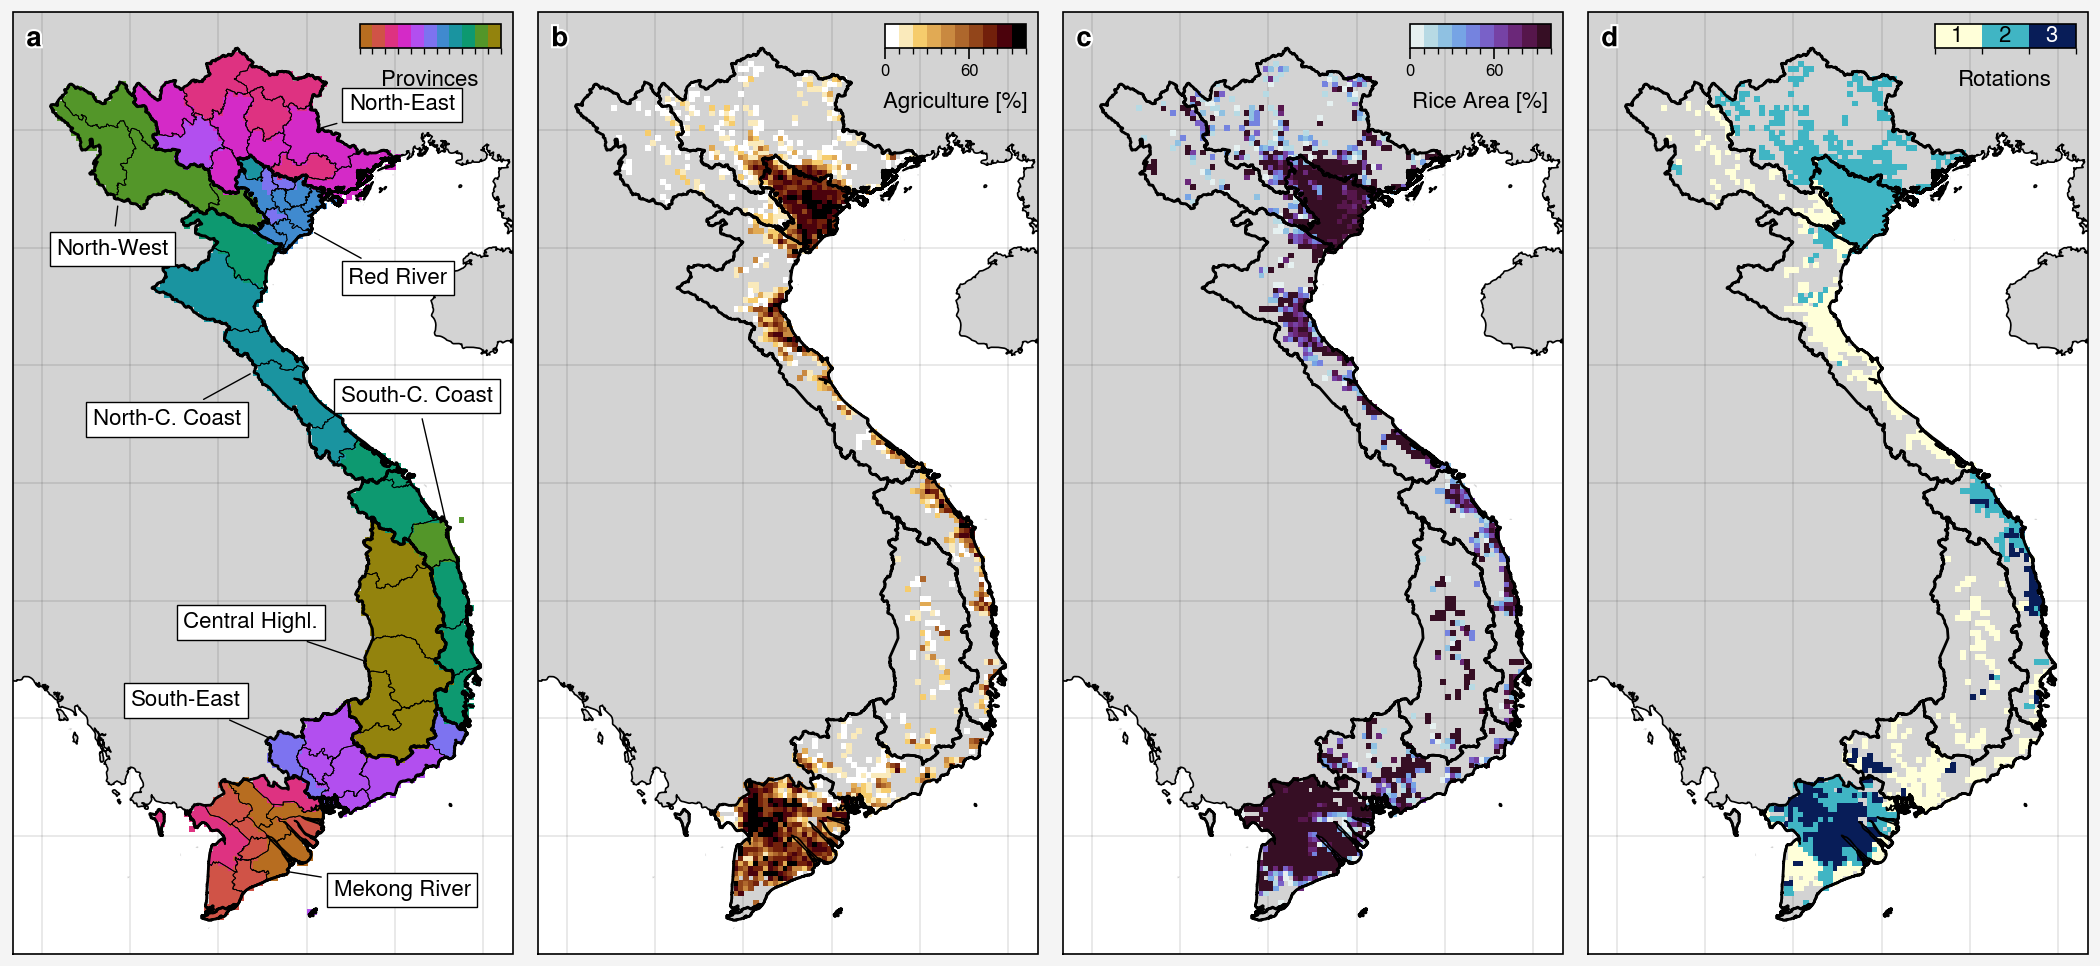

In [120]:
#import matplotlib.patheffects as PathEffects
import copy

def annotate_regions(ax):
    # TODO: figure out why this can onyl run once?!?
    transform = ccrs.PlateCarree()._as_mpl_transform(ax)
 
    for r in range(8):
        Dreg[r]['b'] = (Dreg[r]['a'][0] + Dreg[r]['b'][0], 
                        Dreg[r]['a'][1] + Dreg[r]['b'][1])
       
        ax.annotate(
            Dreg[r]['n'],
            xy=rt(Dreg[r]['a']), 
            xycoords=transform,
            xytext=rt(Dreg[r]['b']),
            size=8, va="bottom", ha="center", color='black',
            bbox=dict(boxstyle="square", fc='white', ec="black", lw=.5),
            arrowprops=dict(arrowstyle="-", fc="black", lw=.5),
            zorder=30,
        )


fig, axs = plot.subplots(ncols=4, nrows=1, proj='cyl')
axs.format(
    land=True,
    reso='hi',
    landcolor='lightgray',
    latlim=(8,24),
    lonlim=(101.5,110),
    abc=True, abcloc='ul', 
)


# -- 0 --
m = axs[0].pcolormesh(misc.provinceid, cmap='Phase', zorder=10)
axs[0].coastlines(zorder=20)
cb = axs[0].colorbar(m, loc='ur', pad='.25em', label='Provinces', width=0.5, length=3, frameon=False, labelsize=8) #Adding colorbar with label
cb.ax.get_xaxis().set_ticks([])
cb.ax.tick_params(labelsize=6)

annotate_regions(axs[0])

axs[0].add_geometries(df_provinces.geometry, fc="None", ec="black", crs=ccrs.PlateCarree(), lw=0.3, zorder=20)
axs[0].add_geometries(df_region.geometry, fc="None", ec="black", crs=ccrs.PlateCarree(), lw=1, zorder=21)

# axs[0].plot(cities.lon, cities.lat, 'r*', mec='k', ms=12, transform=ccrs.PlateCarree(), zorder=25)
# axs[0].text(cities.lon+.375, cities.lat+.375, cities.city_name, color='k', size=12, ha='left', va='center', 
#             transform=ccrs.PlateCarree(), 
#             path_effects=[PathEffects.withStroke(linewidth=2, foreground="w", alpha=1)], zorder=40)

# -- 1 --
m = axs[1].pcolormesh(misc.agrifrac.where(misc.rice_rot>0), cmap='Stellar', zorder=10)
axs[1].coastlines(zorder=20)
axs[1].add_geometries(df_region.geometry, fc="None", ec="black", crs=ccrs.PlateCarree(), lw=1, zorder=21)
cb = axs[1].colorbar(m, loc='ur', pad='.25em', label='Agriculture [%]', width=0.5, length=3, frameon=False, labelsize=8) #Adding colorbar with label
cb.ax.tick_params(labelsize=6)

# -- 2 --
m = axs[2].pcolormesh(misc.rice_fr.where(misc.rice_rot > 0), cmap='Dense', zorder=10)
axs[2].coastlines(zorder=20)
axs[2].add_geometries(df_region.geometry, fc="None", ec="black", crs=ccrs.PlateCarree(), lw=1, zorder=21)
cb = axs[2].colorbar(m, loc='ur', pad='.25em', label='Rice Area [%]', width=0.5,  length=3, frameon=False, labelsize=8) #Adding colorbar with label
cb.ax.tick_params(labelsize=6)

# -- 3 --
m = axs[3].pcolormesh(misc.rice_rot.where(misc.rice_rot > 0), levels=[0, 1, 2, 3], cmap='YlGnBu', zorder=10)
axs[3].coastlines(zorder=20)
axs[3].add_geometries(df_region.geometry, fc="None", ec="black", crs=ccrs.PlateCarree(), lw=1, zorder=21)
cb = axs[3].colorbar(m, loc='ur', pad='.25em', label='Rotations', width=0.5,  length=3, frameon=False, labelsize=8) #Adding colorbar with label
cb.ax.get_xaxis().set_ticks([])
cb.ax.tick_params(labelsize=6)

for j in range(0, 3, 1):
    c = 'white' if j == 2 else 'black'
    cb.ax.text((j+.35) , 0.5, j+1, ha='left', va='center', color=c, fontsize=8)
cb.ax.get_yaxis().labelpad = 5


plot_pdf_png(fig, 'management')